# Fit BAO peak from input correlation function

In [1]:
import numpy as np
import time

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.bao_model import *
from densitysplit.split_fit import *
from densitysplit.utils import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

## Load correlation function poles

### Real or redshift space

In [5]:
rsd = True

if rsd:
    ells = [0, 2]
    f = bg.growth_rate(z)
    sigma_s = 4.
else:
    ells = [0]
    f = 0.
    sigma_s = 0.

### Density split

In [6]:
nells = len(ells)
nsplits = 3
nmocks = 5000

if rsd:
    abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_rh_CCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
    mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_5000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_RSD_all.npy', allow_pickle=True)
else:
    abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_rh_CCFs_cellsize10_randomsize4.npy', allow_pickle=True)
    mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
    #abacus_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_nbarx5_densitySplit_rh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)
    #mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_nbarx5_densitySplit_rh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)

In [7]:
_, cov = get_split_poles(mocks_split_results, ells, nsplits)
xiell = [abacus_split_results[split].get_corr(ells=ells, return_sep=False) for split in range(nsplits)]
#xiell, cov = get_split_poles(mocks_split_results, ells, nsplits)

In [8]:
s, _ = abacus_split_results[0].get_corr(ells=ells, return_sep=True)

In [9]:
cov /= 8.

In [10]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
cov *= hartlap

## Set power spectrum model

In [11]:
bao_model = BAOModel(sep=s, k=np.logspace(-3,2,1000), ells=ells, redshift=z, cosmology=cosmo_abacus, iso=(not rsd), nsplits=nsplits, signature=[True, False, False])

bao_model.set_params(f=f, b=1.87, sigma_s=sigma_s)

In [12]:
bao_model.model_params

{'f': array(0.89781353),
 'b': 1.87,
 'sigma_s': 4.0,
 'alpha_iso': 1.0,
 'F': 1.0,
 'sigma_par': 8.0,
 'sigma_perp': 3.0,
 'bb0_0_DS1': 0,
 'bb1_0_DS1': 0,
 'bb2_0_DS1': 0,
 'bb0_1_DS1': 0,
 'bb1_1_DS1': 0,
 'bb2_1_DS1': 0,
 'bb0_0_DS2': 0,
 'bb1_0_DS2': 0,
 'bb2_0_DS2': 0,
 'bb0_1_DS2': 0,
 'bb1_1_DS2': 0,
 'bb2_1_DS2': 0,
 'bb0_0_DS3': 0,
 'bb1_0_DS3': 0,
 'bb2_0_DS3': 0,
 'bb0_1_DS3': 0,
 'bb1_1_DS3': 0,
 'bb2_1_DS3': 0}

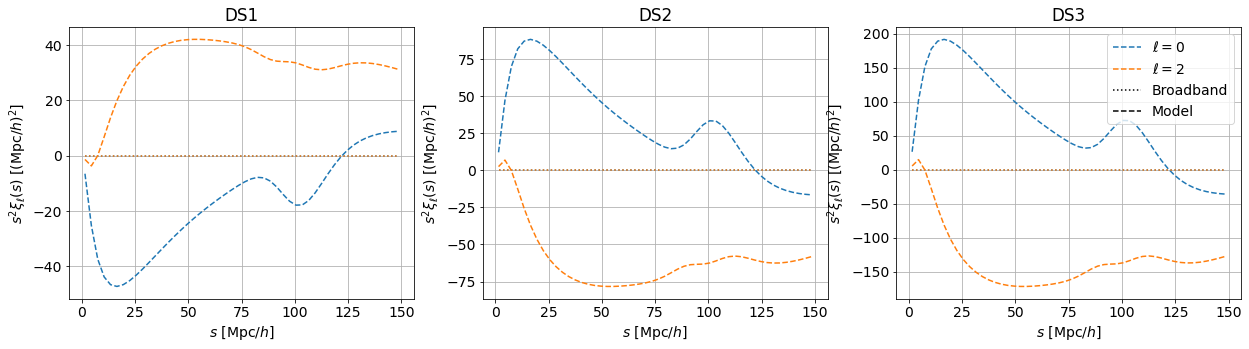

In [13]:
fig, axes = plt.subplots(1, nsplits, figsize=(21, 5), sharey = False)

bao_model.plot_split_model(fig=fig, axes=axes, show_broadband=True)

In [14]:
ds_fit = DensitySplitFit(sep=s, k=np.logspace(-3,2,1000), ells=ells, xiell=xiell, cov=cov, 
                         xi_model=bao_model, model_params=bao_model.model_params, model_params_labels=bao_model.model_params_labels, 
                         nsplits=nsplits)

In [15]:
broadband_coeffs = np.tile([0., 0., 0.], nells)

if rsd:
    params_init = {'alpha_iso': 1., 'F': 1., 'sigma_par': 8., 'sigma_perp': 3.}
else:
    params_init = {'b_DS1': 2., 'b_DS2': 2., 'b_DS3': 2., 'alpha_iso': 1., 'sigma_iso': 5.}
    
#for split in range(bao_model.nsplits):
#    for ill in range(bao_model.nells):
#        for k in range(3):
#            params_init.update({'bb{}_{}_DS{}'.format(k, ill, split+1): 0.})

t1 = time.time()
ds_fit.fit(fit_params_init=params_init, s_lower_limit=50, fit_method='scipy')
t2 = time.time()
print('Execution time: ', t2-t1)

Optimal parameters:
{'alpha_iso': 1.000867275489162, 'F': 0.9614617282186178, 'sigma_par': 8.528438911285198, 'sigma_perp': 10.238587888889725}

Covariance matrix:
[[ 1.08066758e-05 -4.78379929e-06 -8.22279256e-05  1.06099308e-04]
 [-4.78379929e-06  2.04650802e-04  3.21311205e-03 -1.49709788e-03]
 [-8.22279256e-05  3.21311205e-03  6.53757877e-01 -1.72183537e-01]
 [ 1.06099308e-04 -1.49709788e-03 -1.72183537e-01  2.48252592e-01]]

Sigmas:
[0.00328735 0.01430562 0.80855295 0.49824953]
Execution time:  3.552224636077881


[000022.72]  06-22 17:51  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000022.72]  06-22 17:51  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000022.96]  06-22 17:51  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000022.96]  06-22 17:51  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


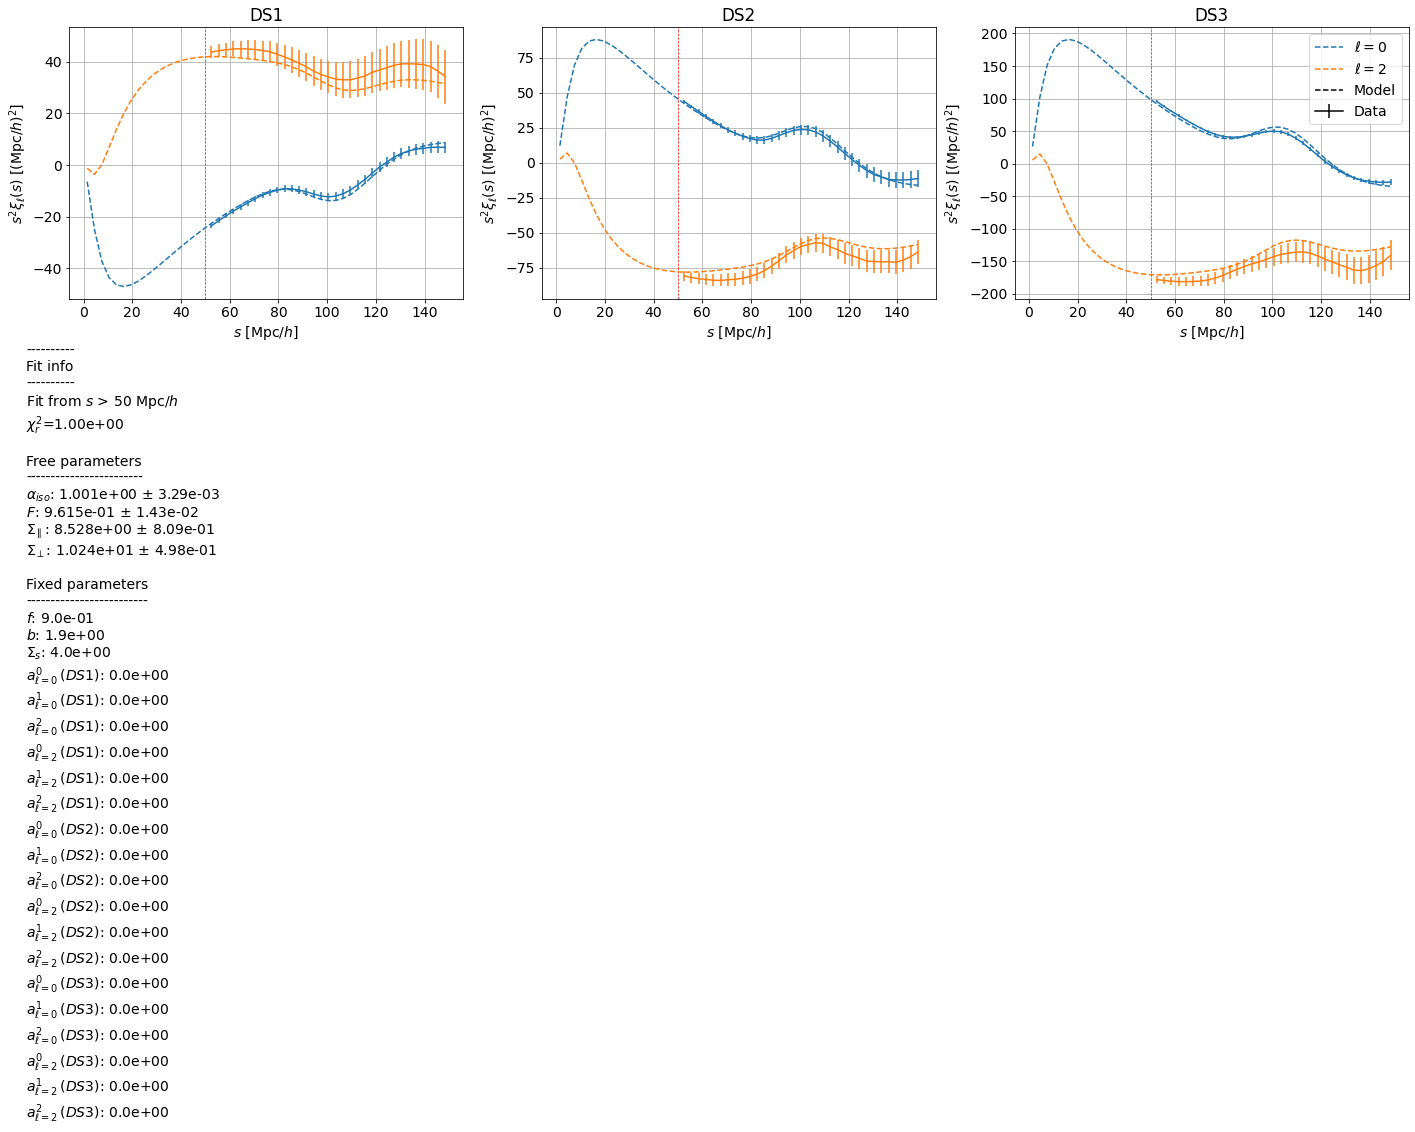

In [16]:
fig, axes = plt.subplots(1, nsplits, figsize=(24, 5), sharey = False)

ds_fit.plot_split_model(fig=fig, axes=axes, show_broadband=False, show_info=True)

In [27]:
bao_model = BAOModel(sep=s, k=np.logspace(-3,2,1000), ells=ells, redshift=z, cosmology=cosmo_abacus, iso=(not rsd), nsplits=nsplits, signature=[True, False, False])

bao_model.set_params(f=0.9, b=1.8, sigma_s=sigma_s)

In [28]:
ds_fit = DensitySplitFit(sep=s, k=np.logspace(-3,2,1000), ells=ells, xiell=xiell, cov=cov, 
                         xi_model=bao_model, model_params=bao_model.model_params, model_params_labels=bao_model.model_params_labels, 
                         nsplits=nsplits)

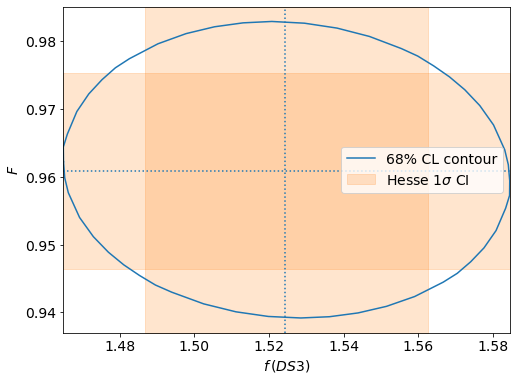

In [29]:
if rsd:
    ds_fit.draw_contour(params=['f_DS3', 'F'], free_params_init=params_init, size=50, s_lower_limit=50)
    
else:
    ds_fit.draw_profile(param='alpha_iso', free_params_init=params_init)
    plt.show()
    ds_fit.draw_profile(param='sigma_iso', free_params_init=params_init)
    plt.show()

In [34]:
ds_fit.free_params

['f_DS1',
 'f_DS2',
 'f_DS3',
 'b_DS1',
 'b_DS2',
 'b_DS3',
 'alpha_iso',
 'F',
 'sigma_par',
 'sigma_perp']

In [30]:
np.save(output_dir+catalog_name+'_3DS_F_f3_contour_f123_b123_free', ds_fit.mncontour)

In [31]:
DS1_contour = np.load(output_dir+catalog_name+'_3DS_F_f1_contour_f123_b123_free.npy')
DS2_contour = np.load(output_dir+catalog_name+'_3DS_F_f2_contour_f123_b123_free.npy')
DS3_contour = np.load(output_dir+catalog_name+'_3DS_F_f3_contour_f123_b123_free.npy')
contour = np.load(output_dir+catalog_name+'_2PCF_F_f_contour_f_b_free.npy')

In [32]:
alpha_iso = [x[0] for x in contour]
alpha_iso.append(alpha_iso[0])
F = [x[1] for x in contour]
F.append(F[0])

DS1_alpha_iso = [x[0] for x in DS1_contour]
DS1_alpha_iso.append(DS1_alpha_iso[0])
DS1_F = [x[1] for x in DS1_contour]
DS1_F.append(DS1_F[0])

DS2_alpha_iso = [x[0] for x in DS2_contour]
DS2_alpha_iso.append(DS2_alpha_iso[0])
DS2_F = [x[1] for x in DS2_contour]
DS2_F.append(DS2_F[0])

DS3_alpha_iso = [x[0] for x in DS3_contour]
DS3_alpha_iso.append(DS3_alpha_iso[0])
DS3_F = [x[1] for x in DS3_contour]
DS3_F.append(DS3_F[0])

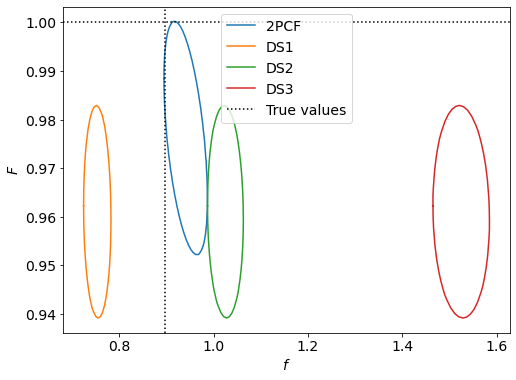

In [33]:
plt.plot(alpha_iso, F, label='2PCF')
plt.plot(DS1_alpha_iso, DS1_F, label='DS1')
plt.plot(DS2_alpha_iso, DS2_F, label='DS2')
plt.plot(DS3_alpha_iso, DS3_F, label='DS3')
plt.xlabel(r'$f$')
plt.axvline(f, linestyle=':', color='black')
plt.axhline(1, linestyle=':', color='black', label='True values')
plt.ylabel(r'$F$')
plt.legend()

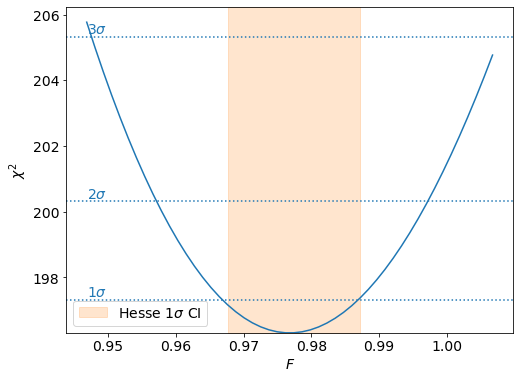

In [36]:
ds_fit.draw_profile(param='F', free_params_init=params_init)

In [37]:
np.save(output_dir+catalog_name+'_3DS_F_profile_f_b_fixed', ds_fit.mnprofile)

In [39]:
DS_locations, DS_profile, DS_status = ds_fit.mnprofile
locations, profile, status = np.load(output_dir+catalog_name+'_2PCF_F_profile_f_b_fixed.npy')

NameError: name 'locations' is not defined

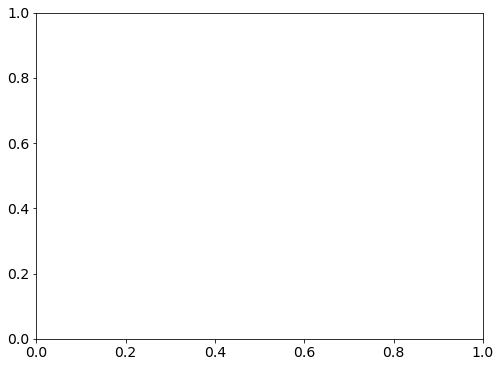

In [21]:
ax=plt.gca()

ax.plot(locations, profile-np.min(profile), label='2PCF')
ax.plot(DS_locations, DS_profile-np.min(DS_profile), label='DS1-3')
ax.set_xlabel(ds_fit.xi_model.model_params_labels['F'])
ax.set_ylabel(r'$\chi^2$')